In [3]:
!pip install pandas numpy matplotlib

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from scipy import interpolate
import datetime as dt
from scipy.integrate import quad

In [12]:
#get our SPX and ATM
import yfinance as yf

start = dt.datetime(2020, 12, 1)
end = dt.datetime(2020, 12, 2)

sp500 =\
(    yf
     .download("^GSPC",
               start,
               end)
)

sp500

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-01,3645.870117,3678.449951,3645.870117,3662.449951,3662.449951,5418480000


In [123]:
S = 3662.45
K = 3660

In [124]:
#load data
df_rate = pd.read_csv('zero_rates_20201201.csv')

df_spx = pd.read_csv('SPX_options.csv')

In [100]:
df_rate.head()

,date,days,rate
0,20201201,7,0.102280
1,20201201,13,0.114128
2,20201201,49,0.216480
3,20201201,77,0.220707
4,20201201,104,0.219996


In [101]:
df_spx.head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style
0,20201201,20201218,C,100000,3547.6,3570.5,E
1,20201201,20201218,C,200000,3447.6,3470.5,E
2,20201201,20201218,C,300000,3347.7,3370.6,E
3,20201201,20201218,C,400000,3247.7,3270.6,E
4,20201201,20201218,C,500000,3147.7,3170.6,E


In [125]:
# Adjust SPX data
df_spx['strike_price'] = df_spx['strike_price'] / 1000
df_spx['mid_price'] = (df_spx['best_bid'] + df_spx['best_offer']) / 2

spx = df_spx[(df_spx['exdate'] == 20210115)]

# Time To Maturity
today = dt.date(2020, 12, 1)
expiry_date = dt.date(2021, 1, 15)
T = (expiry_date - today).days / 365.0

# Discount Rate Interpolation
x = df_rate['days']
y = df_rate['rate']
f = interpolate.interp1d(x,y)
r = f(T * 365) / 100

In [132]:
r

np.float64(0.0020510755555555554)

### model

In [103]:
#Black model
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    return BlackScholesCall(S, K, r, sigma, T) - S + K*np.exp(-r*T)

# Bachelier Model
def BachelierCall(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((S-K)*norm.cdf(d)+S*sigma*np.sqrt(T)*norm.pdf(d))

def BachelierPut(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((K-S)*norm.cdf(-d)+S*sigma*np.sqrt(T)*norm.pdf(-d))

# SABR model
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

## BlackScholes

In [104]:
#Volatility Model for Black
def impliedCallVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 5)

    return impliedVol

def impliedPutVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 5)

    return impliedVol

In [105]:
# ATM Volatility
atm_call = spx[(spx['strike_price'] == K) & (spx['cp_flag'] == "C")]
atm_put = spx[(spx['strike_price'] == K) & (spx['cp_flag'] == "P")]
sigma_call = impliedCallVolatility(S, K, r , atm_call['mid_price'].iloc[0], T)
sigma_put = impliedPutVolatility(S, K, r, atm_put['mid_price'].iloc[0], T)
sigma = (sigma_call + sigma_put)/2
sigma

0.18537188428748586

In [106]:
def callintegrand(K, S, r, T, sigma):
    price = BlackScholesCall(S, K, r, sigma, T) / K**2
    return price


def putintegrand(K, S, r, T, sigma):
    price = BlackScholesPut(S, K, r, sigma, T) / K**2
    return price

F = S * np.exp(r*T)
I_put = quad(lambda x: putintegrand(x, S, r, T, sigma), 0.0, F)
I_call = quad(lambda x: callintegrand(x, S, r, T, sigma), F, 5000)
E_black_var = 2*np.exp(r*T)*(I_put[0] + I_call[0])
print('The expected integrated variance is: %.9f' % E_black_var)

The expected integrated variance is: 0.004236501


## for the Payoff function:

$$
S_0^{1/3} \cdot e^{\left(\frac{1}{3}r - \frac{1}{9} \sigma^2 \right) T} + 1.5 \cdot (ln(S_0) + (r - \frac{1}{2} \sigma^2) T) + 10
$$

In [107]:
# Black Scholes Model
sigma_BSM = np.sqrt(E_black_var/T)

def payoff_bsm(S,r,T,sigma):
    payoff = S ** (1/3) * np.exp((1/3) * r * T - (1/9) *sigma ** 2 * T) + 1.5 * (np.log(S) + r * T - 0.5 * (sigma ** 2) * T) + 10
    return payoff

payoff_bs = payoff_bsm(S,r,T,sigma_BSM)

print('Black-Scholes Model Derivating Pricing: %.9f' % payoff_bs)

Black-Scholes Model Derivating Pricing: 37.714381258


## Bachelier

In [108]:
def callintegrandb(K, S, r, T, sigma):
    price = BachelierCall(S, K, r, sigma, T) / K**2
    return price

def putintegrandb(K, S, r, T, sigma):
    price = BachelierPut(S, K, r, sigma, T) / K**2
    return price

F = S * np.exp(r*T)
I_put = quad(lambda x: putintegrandb(x, S, r, T, sigma), 0.0, F)
I_call = quad(lambda x: callintegrandb(x, S, r, T, sigma), F, 5000)
E_bach_var = 2*np.exp(r*T)*(I_put[0] + I_call[0])

print('Bachelier Model Integrated Variance: %.9f' % E_bach_var)

Bachelier Model Integrated Variance: 0.004263876


## for the Payoff function:

$$
(S_0 + \sigma \cdot T^{\frac{1}{2}} \cdot x) ^{\frac{1}{3}} + 1.5 \cdot ln(S_0 + \sigma \cdot T^{\frac{1}{2}} \cdot x) + 10
$$

$$
V0 = e^{(-rT)} \cdot ((1/2π)^{\frac{1}{2}}) \cdot ∫ bachelier(x) dx
$$

In [109]:
# Bachelier Model
sigma_B = np.sqrt(E_bach_var/T)

x_bachelier = lambda x: (((S + sigma_B*np.sqrt(T)*x)**(1/3))+ (1.5* np.log(S + sigma_B*np.sqrt(T)*x)) + 10) * np.exp(-(x**2/2))
x_b,err = quad(x_bachelier, -(np.inf), np.inf)

derivative_bachelier = np.exp(-r*T)/np.sqrt(2*np.pi)*x_b

print('Bachelier Model Derivative Pricing: %.9f' % derivative_bachelier)

Bachelier Model Derivative Pricing: 37.713596817


## SABR

In [110]:
def SABRCall(S, K, r, alpha, beta, rho, nu, T):
    sabr_vol = SABR(S*np.exp(r*T), K, T, alpha, beta, rho, nu)
    return BlackScholesCall(S, K, r, sabr_vol, T)


def SABRPut(S, K, r, alpha, beta, rho, nu, T):
    sabr_vol = SABR(S*np.exp(r*T), K, T, alpha, beta, rho, nu)
    return BlackScholesPut(S, K, r, sabr_vol, T)


def sabrcallintegrand(K, S, r, T, alpha, beta, rho, nu):
    price = SABRCall(S, K, r, alpha, beta, rho, nu, T) / K**2
    return price


def sabrputintegrand(K, S, r, T, alpha, beta, rho, nu):
    price = SABRPut(S, K, r, alpha, beta, rho, nu, T) / K**2
    return price

In [130]:
# calculate the model parameters
from scipy.optimize import least_squares

beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err


def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol


def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

#####
# Here, load DataFrame with strike and implied volatility information into "df"
#####
df = spx.copy()
df['mid'] = df['mid_price']
df['strike'] = df['strike_price']
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(df['exdate'].unique())[0]
df = df[df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
S = 3662.45
r = f(T * 365) / 100
F = S*np.exp(r*T)


df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df['strike'],
                                              df['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

C:\Users\86159\AppData\Local\Temp\ipykernel_34400\3075488719.py:21: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
C:\Users\86159\AppData\Local\Temp\ipykernel_34400\3075488719.py:21: RuntimeWarning: invalid value encountered in scalar power
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790


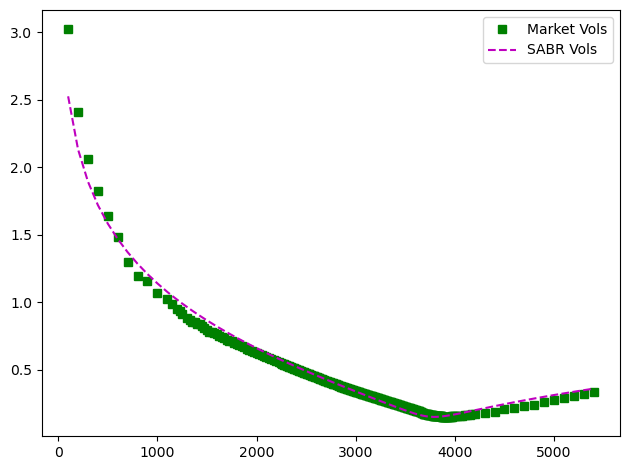

In [131]:
plt.figure(tight_layout=True)
plt.plot(strikes, df['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.legend()
plt.show()

In [128]:
alpha = 1.817
beta = 0.7
rho = -0.404
nu = 2.790

F = S * np.exp(r*T)
I_put = quad(lambda x: sabrputintegrand(x, S, r, T, alpha, beta, rho, nu), 1e-6, F)
I_call = quad(lambda x: sabrcallintegrand(x, S, r, T, alpha, beta, rho, nu), F, 5000)
E_var_SABR = 2*np.exp(r*T)*(I_put[0] + I_call[0])

print('SABR Model Integrated Variance: %.9f' % E_var_SABR)

SABR Model Integrated Variance: 0.006337324


In [129]:
sigma_SABR = np.sqrt(E_var_SABR/T)

x_SABR_bachelier = lambda x: (((S + sigma_SABR*np.sqrt(T)*x)**(1/3))+ (1.5* np.log(S + sigma_SABR*np.sqrt(T)*x)) +10 )*np.exp(-(x**2/2))
x_SABR,err = quad(x_SABR_bachelier, -(np.inf), np.inf)

derivative_SABR_bachelier = np.exp(-r*T)/np.sqrt(2*np.pi)*x_SABR

print('Bachelier Model Derivative Pricing (SABR): %.9f' % derivative_SABR_bachelier)

payoff_SABR_bs = payoff_bsm(S,r,T,sigma_SABR)

print('Black-Scholes Model Derivative Pricing (SABR): %.9f' % payoff_SABR_bs)

Bachelier Model Derivative Pricing (SABR): 37.713596817
Black-Scholes Model Derivative Pricing (SABR): 37.709209373
